In [3]:
%load_ext autoreload
%autoreload 2
import numpy as np
import os
import sys
sys.dont_write_bytecode = True
sys.path.append(os.path.dirname(os.path.dirname((os.path.abspath("single_node_profiles_cpp")))))
import optimizer.single_node_profiles_cpp as snp
import optimizer.profiler
import numpy as np
import seaborn as sns

from optimizer.optimizer import GreedyOptimizer
from IPython.display import display
import matplotlib.pyplot as plt
import optimizer.utils
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
with open("../experiments/cached_arrival_processes/58_4.0.deltas", 'r') as f:
    deltas = np.array([float(l.strip()) for l in f]).flatten()
len(deltas), deltas

(50000, array([24.75306748, 53.60485031, 77.32838437, ..., 65.29555097,
        60.21801125,  2.06832863]))

In [6]:
resnet_array = np.array([
       [1,  132.54010, 10.0],
       [2,  134.24957, 19.7],
       [4,  138.39000, 38.6],
       [8,  149.21285, 76.1],
       [12, 152.38963, 105.2],
       [16, 172.64560, 126.2],
       [24, 212.01610, 168.9],
       [32, 256.63817, 191.5]])
inception_array=resnet_array[np.argsort(resnet_array[:,0])]
inception_array = np.array([
       [1,  68.10305,  26.3],
       [2,  72.8235,   45.8],
       [4,  73.88426,  81.5],
       [8,  105.866700, 132.8],
       [12, 112.031640, 179.5],
       [16, 149.952640, 199.5],
       [24, 195.421250, 213.0]])
inception_array=inception_array[np.argsort(inception_array[:,0])]

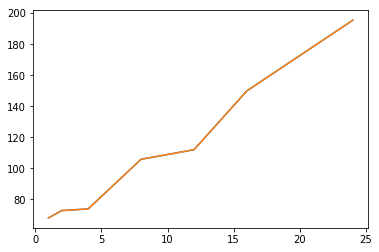

In [7]:
def line_segment_function(x,y):
    def result(x_point):
        if x_point in x:
            return y[x == x_point][0]
        less_index = max(np.arange(len(x))[x < x_point])
        more_index = min(np.arange(len(x))[x > x_point])
        rise = y[more_index] - y[less_index]
        run = x[more_index] - x[less_index]
        slope = float(rise)/run
        delta = x_point - x[less_index]
        return y[less_index] + delta*slope
    return result

batches = inception_array[:,0]
latencies = inception_array[:,1]

plt.plot(batches, latencies)
smoothed_fn = line_segment_function(batches, latencies)
plt.plot(batches, [smoothed_fn(batch) for batch in batches])

In [8]:
class Scheduler(object):
    def __init__(self):
        self.time = 0
        self.scheduled = []
    
    def schedule(self, fn, in_how_long):
        index = 0
        current_time_to_schedule = self.time + in_how_long
        for item_scheduled_time,_ in self.scheduled:
             if item_scheduled_time < current_time_to_schedule:
                index+=1
        self.scheduled.insert(index, [self.time + in_how_long, fn])
    
    def start(self):
        while self.scheduled != []:
            next_event_time, fn = self.scheduled.pop(0)
            self.time = next_event_time
            fn(self.time)
            while self.scheduled != [] and np.isclose(self.scheduled[0][0], next_event_time):
                next_event_time, fn = self.scheduled.pop(0)
                fn(self.time)

class Node(object):
    def __init__(self, name, scheduler):
        self.children = []
        self.parents = []
        self.name = name
        self.scheduler = scheduler
    
    def then(self, child):
        self.children.append(child)
        child.parents.append(self)
    
class SourceNode(Node):
    def __init__(self, deltas, scheduler):
        Node.__init__(self, "source", scheduler)
        self.deltas = deltas
        self.deltas_index = 0
        # Schedule the first query to send
        self.scheduler.schedule(self.send_query, 0)
    
    def send_query(self, time):
        for child in self.children:
            self.scheduler.schedule(lambda time: child.arrival({}, time), 0)
        if self.deltas_index < len(self.deltas):
            self.scheduler.schedule(self.send_query, self.deltas[self.deltas_index])
            self.deltas_index+=1
    
class BatchedNode(Node):
    def __init__(self, max_batch_size, smoothed_fn, name, scheduler, batching_delay=0):
        Node.__init__(self, name, scheduler)
        self.max_batch_size = max_batch_size
        self.smoothed_fn = smoothed_fn
        self.scheduler = scheduler
        self.batching_delay = batching_delay
        self.queue = []
        self.queue_size_over_time = []
        self.batch_sizes_over_time = []
        self.in_model = []
        self.model_idle = True
    
    def arrival(self, query, time):
#         print "model arrive"
        query[self.name+"_enqueue_time"] = time
        self.queue.append(query)
        self.queue_size_over_time.append([time, len(self.queue)])
        if self.model_idle:
            scheduler.schedule(self.model_take, self.batching_delay)
            self.model_idle = False
    
    def model_take(self, time):
#         print "model take"
        assert len(self.queue) > 0
        num_taken_to_process = min(len(self.queue), self.max_batch_size)
        self.in_model = self.queue[:num_taken_to_process]
        self.queue = self.queue[num_taken_to_process:] # dequeue from queue
        for query in self.in_model:
            query[self.name+"_dequeue_time"] = time
            query[self.name+"_batchsize"] = num_taken_to_process
        self.queue_size_over_time.append([time, len(self.queue)])
        self.batch_sizes_over_time.append([time, num_taken_to_process])
        self.scheduler.schedule(self.model_return, self.smoothed_fn(num_taken_to_process)) # service time of batch
    
    def model_return(self, time):
#         print "model return"
        for query in self.in_model:
            query[self.name+"_service_time"] = time
            for child in self.children:
                self.scheduler.schedule(lambda time: child.arrival(query, time), 0)
        self.in_model = []
        if len(self.queue) == 0:
            self.model_idle = True
        else:
            self.scheduler.schedule(self.model_take, self.batching_delay)

class SinkNode(Node):
    def __init__(self, scheduler):
        Node.__init__(self, "sink", scheduler)
        self.queue = []
        self.counter = 0
    
    def arrival(self, query, time):
        self.counter+=1
        if self.counter % 1000 == 0:
            print self.counter
        self.queue.append(query)
    

In [9]:
batches = inception_array[:,0]
over_latencies = 1/(inception_array[:,2]/1000)
smoothed_fn=line_segment_function(batches, over_latencies*batches)

scheduler = Scheduler()
source = SourceNode(deltas, scheduler)
inception = BatchedNode(max_batch_size=16, smoothed_fn=smoothed_fn, name="Inception", scheduler=scheduler, batching_delay=0)
sink = SinkNode(scheduler)
source.then(inception)
inception.then(sink)
scheduler.start()
queue_size_over_time, batch_sizes_over_time = np.asarray(inception.queue_size_over_time), np.asarray(inception.batch_sizes_over_time)
final_lineage_result = sink.queue

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000


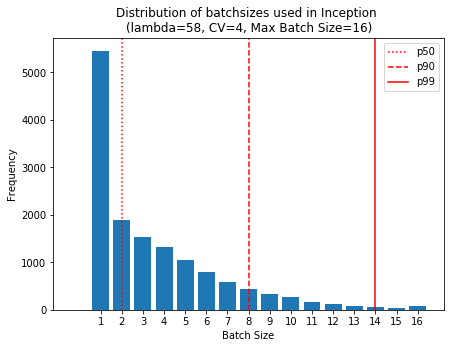

In [93]:
plt.figure(figsize=(7,5))
plt.title("Distribution of batchsizes used in Inception \n(lambda=58, CV=4, Max Batch Size=16)")
plt.xlabel("Batch Size")
plt.ylabel("Frequency")
plt.xticks(np.arange(1,17))
plt.axvline(x=np.percentile(batch_sizes_over_time[:,1], 50), color="red", linestyle=":", label="p50")
plt.axvline(x=np.percentile(batch_sizes_over_time[:,1], 90), color="red", linestyle="--", label="p90")
plt.axvline(x=np.percentile(batch_sizes_over_time[:,1], 99), color="red", label="p99")
plt.bar(np.arange(16+1), np.bincount(batch_sizes_over_time[:,1].astype(int)))
plt.legend()

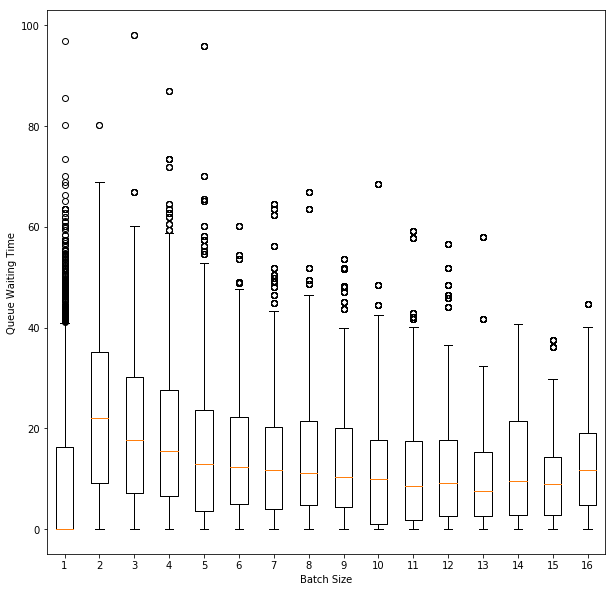

In [79]:
queue_waiting_time = np.asarray([q['Inception_dequeue_time']-q['Inception_enqueue_time'] for q in final_lineage_result])
batch_size = np.asarray([q['Inception_batchsize'] for q in final_lineage_result])
botxplot_data = []
plt.figure(figsize=(10,10))
plt.xlabel("Batch Size")
plt.ylabel("Queue Waiting Time")
for i in np.arange(16)+1:
    queue_waiting_time_for_batchsize = queue_waiting_time[batch_size == i]
    botxplot_data.append(queue_waiting_time_for_batchsize)
plt.boxplot(botxplot_data, positions=np.arange(16)+1);
# plt.scatter(batch_size, queue_waiting_time)

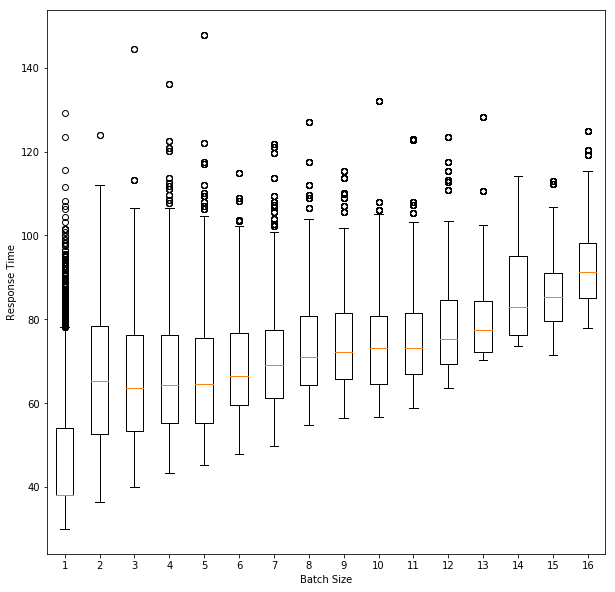

In [85]:
response_waiting_time = np.asarray([q['Inception_service_time']-q['Inception_enqueue_time'] for q in final_lineage_result])
batch_size = np.asarray([q['Inception_batchsize'] for q in final_lineage_result])
botxplot_data = []
plt.figure(figsize=(10,10))
plt.xlabel("Batch Size")
plt.ylabel("Response Time")
for i in np.arange(16)+1:
    response_waiting_time_for_batchsize = response_waiting_time[batch_size == i]
    botxplot_data.append(response_waiting_time_for_batchsize)
plt.boxplot(botxplot_data, positions=np.arange(16)+1);
# plt.scatter(batch_size, response_waiting_time)

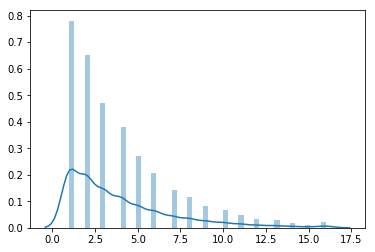

In [33]:
sns.distplot(batch_sizes_over_time[:,1])

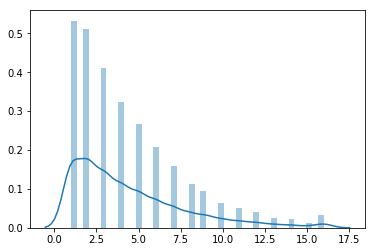

In [37]:
sns.distplot(batch_sizes_over_time[:,1])

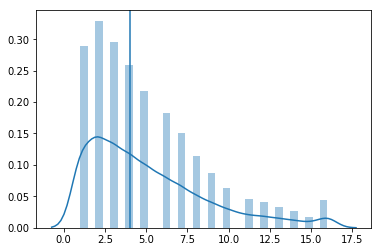

In [44]:
sns.distplot(batch_sizes_over_time[:,1])
plt.axvline(x = np.percentile(batch_sizes_over_time[:,1], 50))

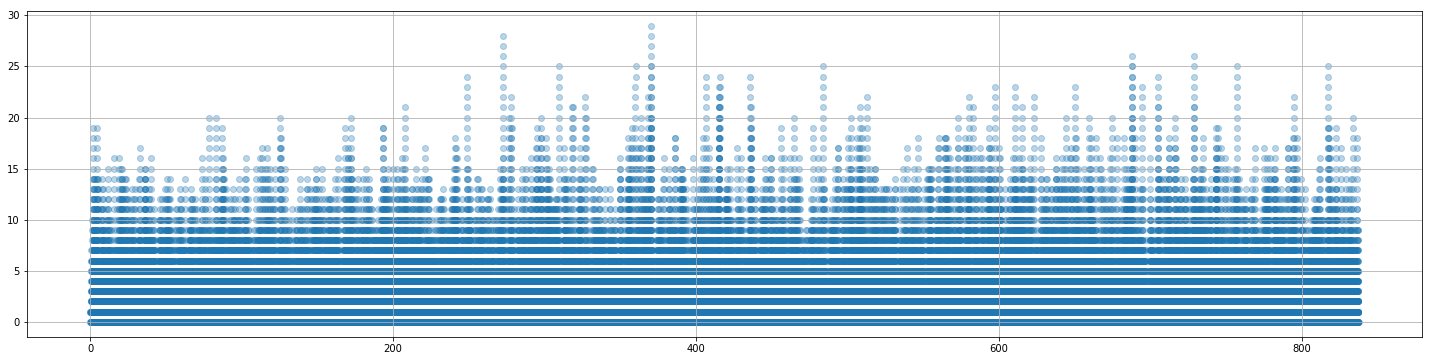

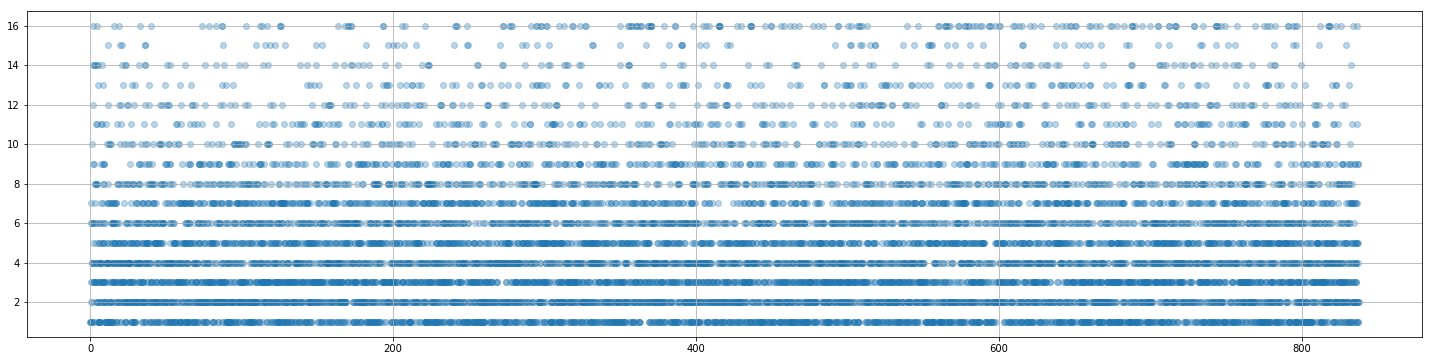

In [42]:
plt.figure(figsize=(25,6))
plt.scatter(queue_size_over_time[:,0]/1000., queue_size_over_time[:,1],alpha=0.3)
plt.grid()
plt.figure(figsize=(25,6))
plt.scatter(batch_sizes_over_time[:,0]/1000., batch_sizes_over_time[:,1],alpha=0.3)
plt.grid()

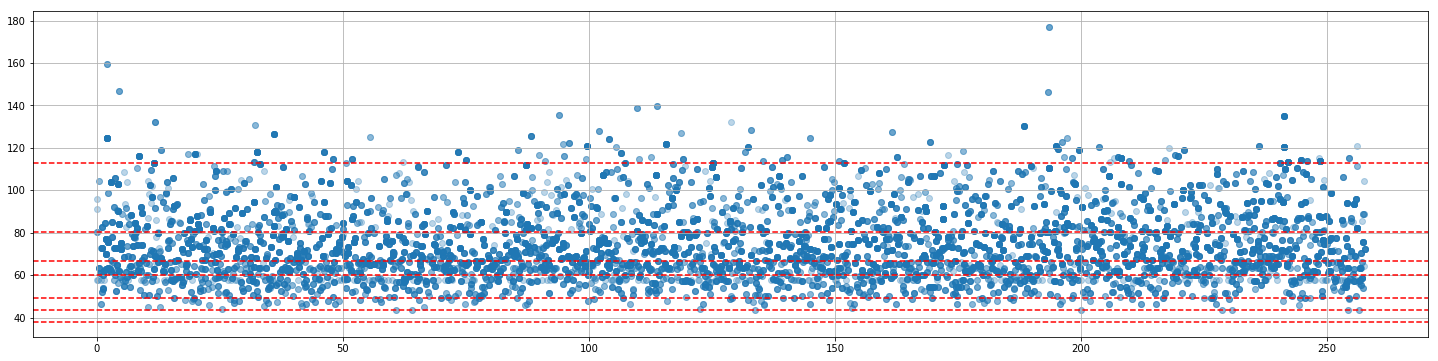

In [43]:
response_time = np.asarray([[q['Inception_enqueue_time'], q['Inception_service_time']-q['Inception_enqueue_time']] for q in final_lineage_result])[:15000]
plt.figure(figsize=(25,6))
for l in batches*over_latencies:
    plt.axhline(y=l, linestyle="--", color="red")
plt.scatter(response_time[:,0]/1000., response_time[:,1],alpha=0.3)
plt.grid()

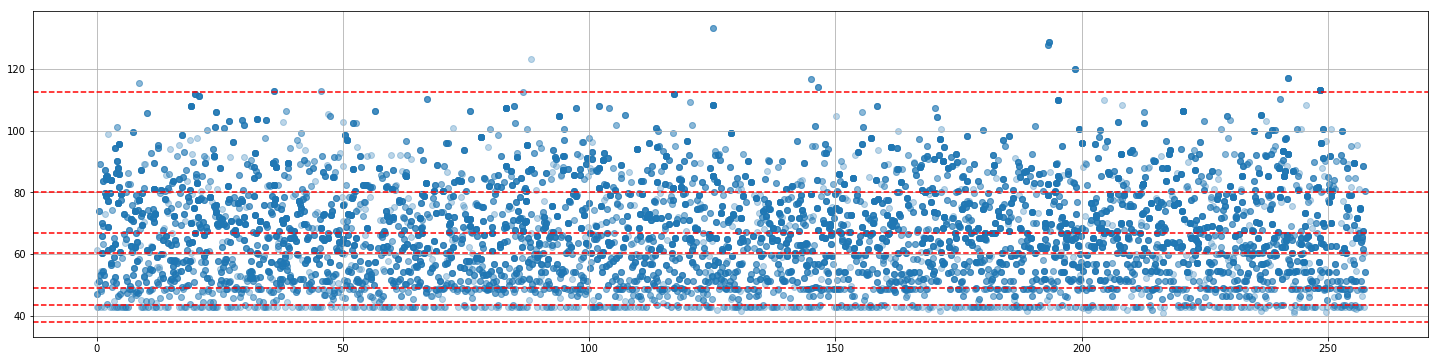

In [35]:
response_time = np.asarray([[q['Inception_enqueue_time'], q['Inception_service_time']-q['Inception_enqueue_time']] for q in final_lineage_result])[:15000]
plt.figure(figsize=(25,6))
for l in batches*over_latencies:
    plt.axhline(y=l, linestyle="--", color="red")
plt.scatter(response_time[:,0]/1000., response_time[:,1],alpha=0.3)
plt.grid()

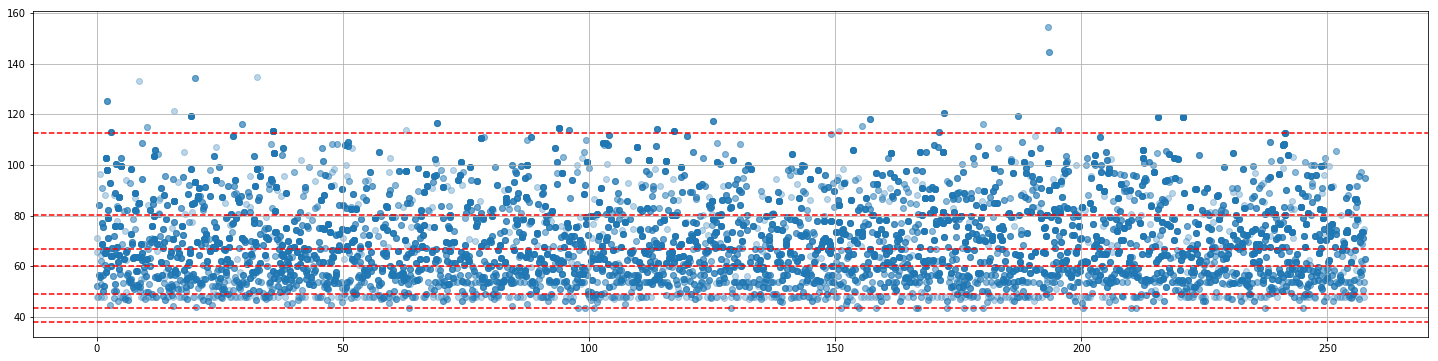

In [39]:
response_time = np.asarray([[q['Inception_enqueue_time'], q['Inception_service_time']-q['Inception_enqueue_time']] for q in final_lineage_result])[:15000]
plt.figure(figsize=(25,6))
for l in batches*over_latencies:
    plt.axhline(y=l, linestyle="--", color="red")
plt.scatter(response_time[:,0]/1000., response_time[:,1],alpha=0.3)
plt.grid()

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000


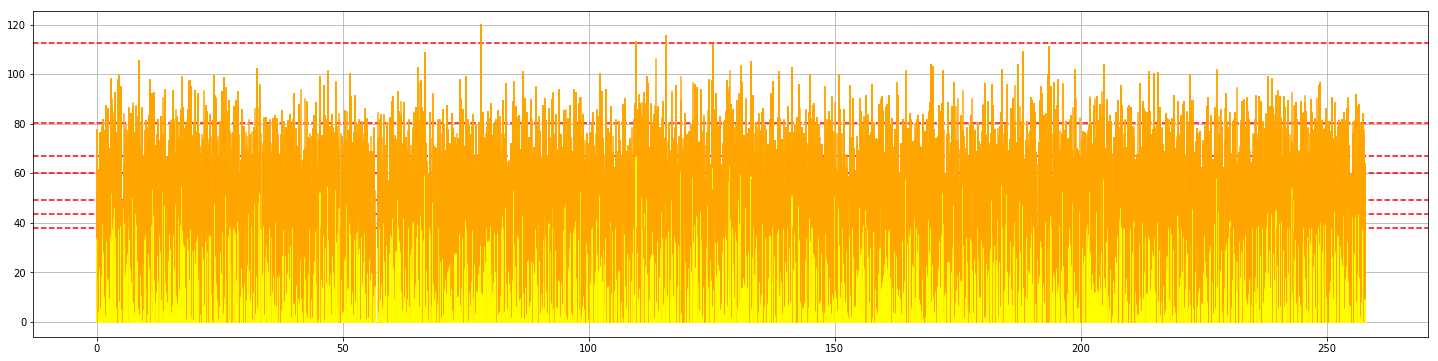

In [58]:
queue_waiting_time = np.asarray([[q['Inception_enqueue_time'], q['Inception_dequeue_time']-q['Inception_enqueue_time']] for q in final_lineage_result])[:15000]
processing_time = np.asarray([[q['Inception_enqueue_time'], q['Inception_service_time']-q['Inception_dequeue_time']] for q in final_lineage_result])[:15000]
plt.figure(figsize=(25,6))
for l in batches*over_latencies:
    plt.axhline(y=l, linestyle="--", color="red")
counter = 0
for (time1, queue_time), (time2, process_time) in zip(queue_waiting_time, processing_time):
    assert time1 == time2
    time = time1
    plt.plot([time/1000., time/1000], [0, queue_time], color="yellow")
    plt.plot([time/1000., time/1000], [queue_time, queue_time+process_time], color="orange")
    if counter % 1000 == 0:
        print counter
    counter+=1
# plt.scatter(response_time[:,0]/1000., response_time[:,1],alpha=0.3, color="red")
plt.grid()

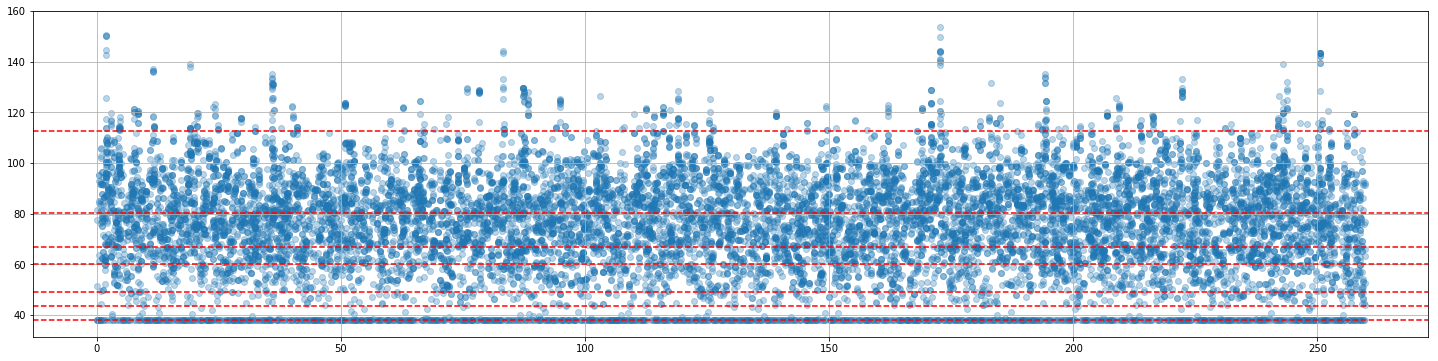

In [438]:
response_time = np.asarray([[q['enqueue_time'], q['service_time']-q['enqueue_time']] for q in final_lineage_result])[:15000]
plt.figure(figsize=(25,6))
for l in batches*over_latencies:
    plt.axhline(y=l, linestyle="--", color="red")
plt.scatter(response_time[:,0]/1000., response_time[:,1],alpha=0.3)
plt.grid()

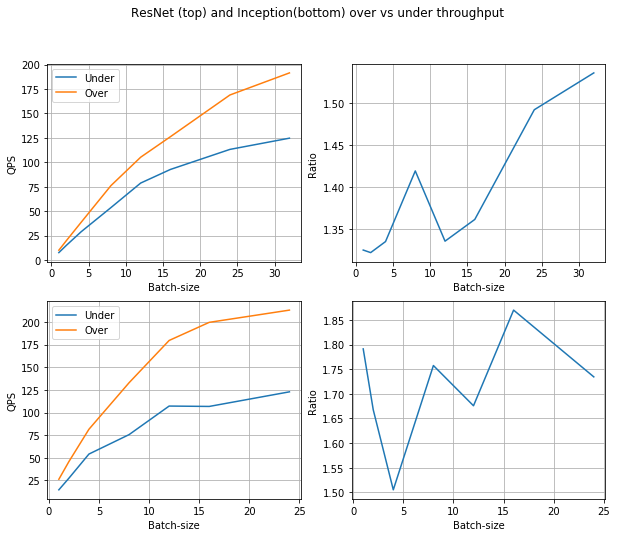

In [177]:
under_thru = resnet_array[:,0]*1/(resnet_array[:,1]/1000)
over_thru = resnet_array[:,2]
batches = resnet_array[:,0]
plt.figure(figsize=(10,8))
plt.suptitle("ResNet (top) and Inception(bottom) over vs under throughput")
plt.subplot(2,2,1)
plt.xlabel("Batch-size")
plt.ylabel("QPS")
plt.plot(batches, under_thru, label = "Under")
plt.plot(batches, over_thru, label = "Over")
plt.legend()
plt.grid()
plt.subplot(2,2,2)
plt.xlabel("Batch-size")
plt.ylabel("Ratio")
plt.plot(batches, over_thru/under_thru)
plt.grid()
under_thru = inception_array[:,0]*1/(inception_array[:,1]/1000)
over_thru = inception_array[:,2]
batches = inception_array[:,0]
plt.subplot(2,2,3)
plt.xlabel("Batch-size")
plt.ylabel("QPS")
plt.plot(batches, under_thru, label="Under")
plt.plot(batches, over_thru, label="Over")
plt.legend()
plt.grid()
plt.subplot(2,2,4)
plt.xlabel("Batch-size")
plt.ylabel("Ratio")
plt.plot(batches, over_thru/under_thru)
plt.grid()

In [294]:
# Good for plotting but not for anlysis, shifts the x values for some reason so that they don't start at min(x)
def smoothed_line_segment_function(x,y):
    from scipy.ndimage.filters import gaussian_filter
    x_new = np.linspace(min(x), max(x), 200)
    print x_new
    fn = line_segment_function(x,y)
    y_new = [fn(x_point) for x_point in x_new]
    together = np.vstack([x_new,y_new]).T
    smoothed_together = gaussian_filter(together, [3,0.1])
    print smoothed_together[:,0]
    return line_segment_function(smoothed_together[:,0], smoothed_together[:,1])

In [435]:
# Backup from 5/15 at 11:18AM
class TimeKeeper(object):
    def __init__(self, deltas, max_batch_size, smoothed_fn, batching_delay=0):
        self.queue = []
        self.time = 0
        self.max_batch_size = max_batch_size
        self.smoothed_fn = smoothed_fn
        self.deltas_index = 0
        self.response_latencies_over_time = []
        self.queue_size_over_time = []
        self.deltas = deltas
        self.batching_delay = batching_delay
    
    def run(self):
        time = 0
        queue = []
        next_event = "arrival" # or service
        time_until_arrival = 0
        time_until_service = np.inf # starts infinite because there is nothing in the model
        time_until_event = min(time_until_arrival, time_until_service)
        deltas_index = 0
        in_model = []
        queue_size_over_time = []
        final_lineage_result = []
        batch_sizes_over_time = []
        while True: # Each iteration in this loop is an event, either a queue arrival or a service finishing
            time+=time_until_event # update time to the event
            time_until_arrival-=time_until_event
            time_until_service-=time_until_event
            assert time_until_service >=0
            if next_event == "arrival":
                queue.append({"enqueue_time":time})
                queue_size_over_time.append([time, len(queue)])
                time_until_arrival = np.inf if deltas_index == len(deltas) else deltas[deltas_index]
                deltas_index+=1
            elif next_event == "service":
                for query in in_model: # add timestamps of queries that finished and add to lineage list
                    query["service_time"] = time
                    final_lineage_result.append(query)
                in_model = []
                num_taken_to_process = min(len(queue), self.max_batch_size)
                if num_taken_to_process == 0:
                    time_until_service = np.inf
                else:
                    batch_sizes_over_time.append([time,num_taken_to_process])
                    in_model = queue[:num_taken_to_process]
                    queue = queue[num_taken_to_process:] # dequeue from queue
                    queue_size_over_time.append([time, len(queue)])
                    for query in in_model:
                        query["dequeue_time"] = time
                    time_until_service = self.smoothed_fn(num_taken_to_process) # service time of batch
            else:
                raise Exception("Unknown event")
            if len(queue) > 0 and time_until_service == np.inf:
                time_until_service = 0
            # figure out which event will happen next
            next_event = "arrival" if time_until_arrival < time_until_service else "service"
            time_until_event = min(time_until_arrival, time_until_service)
            if time_until_event == np.inf: # If both time until arrival and time until service are both marked as infinite, it means that the there are no more queries to arriva and the model is empty
                break
        return final_lineage_result, np.asarray(queue_size_over_time), np.asarray(batch_sizes_over_time)

In [436]:
p99_latencies = inception_array[:,1]
over_latencies = 1/(inception_array[:,2]/1000)
print over_latencies*batches
batches = inception_array[:,0]
timekeeper = TimeKeeper(deltas=deltas, 
                        max_batch_size=16, 
                        smoothed_fn=line_segment_function(batches, over_latencies*batches))

final_lineage_result, queue_size_over_time, batch_sizes_over_time = timekeeper.run()

[ 38.02281369  43.66812227  49.0797546   60.24096386  66.85236769
  80.20050125 112.67605634]


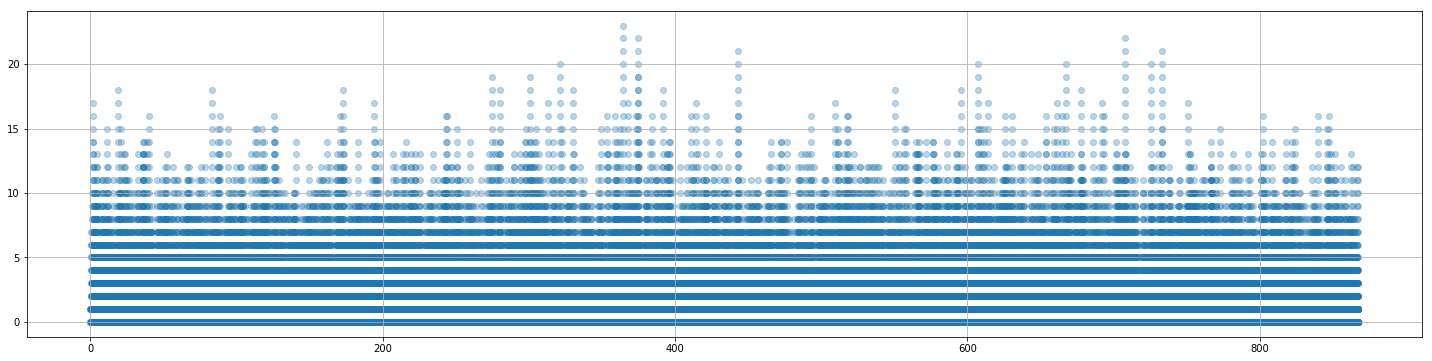

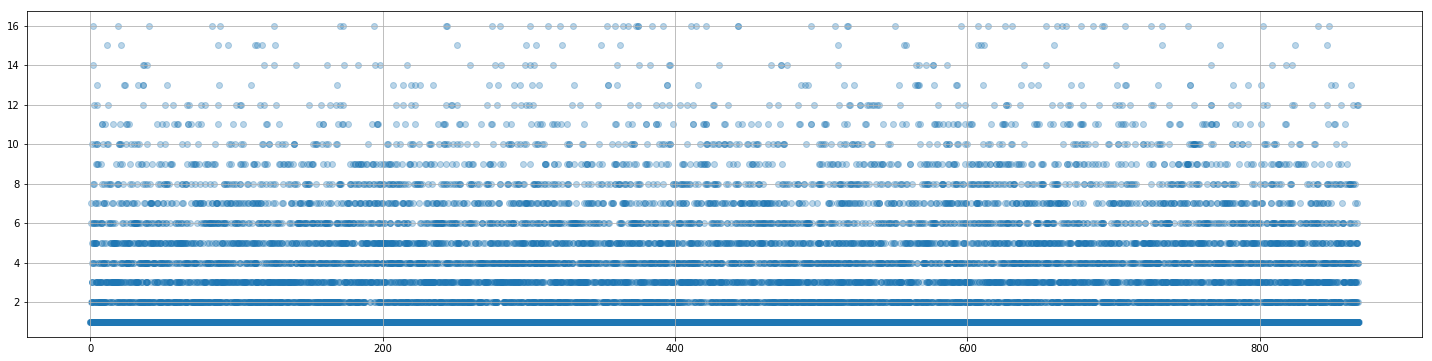

In [437]:
plt.figure(figsize=(25,6))
plt.scatter(queue_size_over_time[:,0]/1000., queue_size_over_time[:,1],alpha=0.3)
plt.grid()
plt.figure(figsize=(25,6))
plt.scatter(batch_sizes_over_time[:,0]/1000., batch_sizes_over_time[:,1],alpha=0.3)
plt.grid()

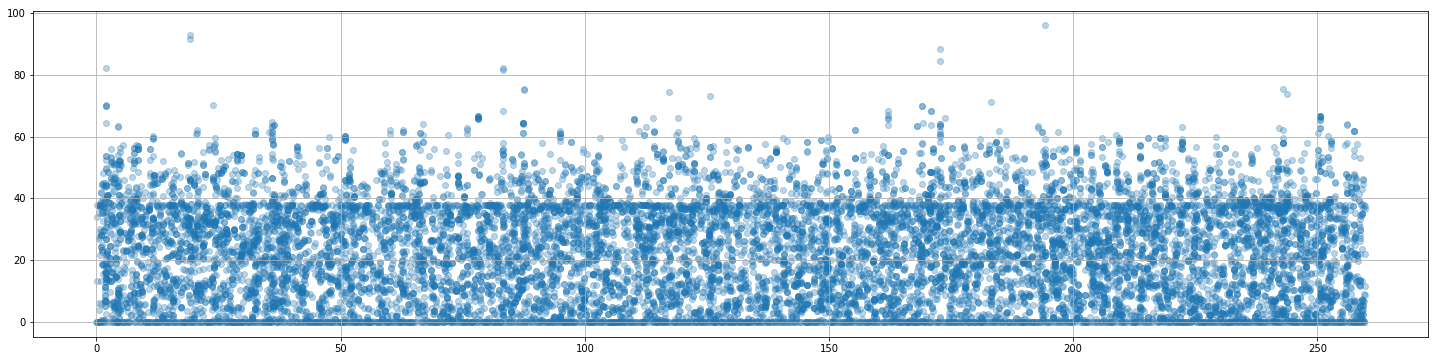

In [362]:
queue_waiting_times = np.asarray([[q['enqueue_time'], q['dequeue_time']-q['enqueue_time']] for q in final_lineage_result])[:15000]
plt.figure(figsize=(25,6))
plt.scatter(queue_waiting_times[:,0]/1000., queue_waiting_times[:,1],alpha=0.3)
plt.grid()